Based on the results of V6, this version is limited to vectorization = BoW and topic modeling = LDA with number of topics = 6 with the target
to derive a topic proposal for the imported data of 2021 for the product "Credit reporting, credit repair services, or other personal consumer reports".

# (1) Import of needed libraries

In [1]:
# import pandas for data import and manipulation 
import pandas as pd

# import pyplot for visualizing purposes
import matplotlib
import matplotlib.pyplot as plt

# import nltk for data pre-processing including tokenization, lemmatization and stemming 
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk import bigrams

# import gensim and numpy for vectorization (BoW and Tfidf) and topic modeling (LSI, LDA and HDP)
import gensim
import numpy as np
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import HdpModel

# (2) Import of complaint data

In [2]:
# Importing csv (source: https://www.kaggle.com/datasets/sherrytp/consumer-complaints)
# Defining data type of ZIP code as string due to mixed data types within column
df = pd.read_csv('complaints.csv',dtype = {'ZIP code': str})

# Showing full column content
pd.set_option('display.max_colwidth', None)

# Showing the first five table entries
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",TX,78541,Servicemember,NaN,Web,2022-11-19,In progress,Yes,NaN,6222374
1,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,"In accordance with the fair credit reporting act XXXX account XXXX XXXX # XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Has violated my rights,15 U.S.C.1681 section 602 A states that I have a right to my privacy. 1 5 U.S.C. 1681 section 602 A section 2 states a consumer reporting company can not furnish an account without my written instructions which I have never given.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30043,NaN,Consent provided,Web,2022-10-13,Closed with explanation,Yes,NaN,6079679
2,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Again, I was going through my records & noticed the fraudulent accounts which do not belong to me STILL reposting on my file in Transunion. The other bureaus have already DELETED this fraudulent information so my question is why do you still report these damaging records? I also contacted XXXX XXXX XXXX and then talked to their staff, and they agreed to remove the accounts from my file. I have already disputed these accounts several times and stated that I am an identity theft victim. I even forwarded my FTC report I filed online on their website along with my personal information and documents but still, you chose to continue reporting these accounts. Credit Bureaus are bound to comply with the FCRA regulation section 605b but you never cared nor paid any attention to my Disputes. You became negligent of the FCRA law and continued reporting this information on my Credit File without Proper Verification or Investigation. Now, I want you to REMOVE these items from my file like the other bureaus have done. \n\nXXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90660,NaN,Consent provided,Web,2022-10-13,Closed with non-monetary relief,Yes,NaN,6076990
3,2022-10-12,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19148,NaN,Consent not provided,Web,2022-10-12,Closed with non-monetary relief,Yes,NaN,6080312
4,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Na

# (3) Data Pre-Processing

## (3.1.a) Data Filtering (1/2)

Number of complaints: 203598


<Axes: xlabel='Product'>

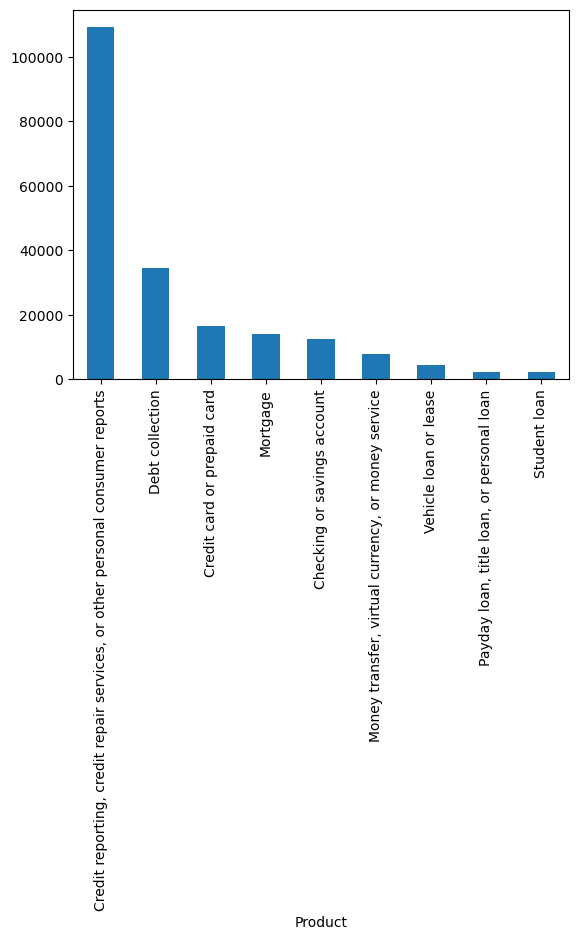

In [3]:
# Focus of the analysis will be on the unstructured consumer complaint narrative
# Product and Date will be kept for subsequent filtering purposes to narrow down the data
df = df[['Complaint ID','Date received', 'Product','Consumer complaint narrative']]
df['Date received']= pd.to_datetime(df['Date received'])

# Removal of records where the column "Consumer complaint narrative" is equal to "NaN"
df = df[df['Consumer complaint narrative'].notna()]

# Limit to one year
df = df[(df['Date received'].dt.year == 2021)]

# Determine the number of complaints/documents/rows
print("Number of complaints:", len(df))

# Printing the number of complaints per product to identify the respective distribution and subsequently further restrict the data
df['Product'].value_counts().plot(kind='bar')

## (3.1.b) Data Filtering (2/2)

In [4]:
# Focusing on one product category to focus on a specific topic
df = df[(df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports') ]

# Printing the number of complaints under consideration for all the subsequent NLP steps
print("Number of complaints:", len(df))

# Filter out duplications
df = df.drop_duplicates(subset=['Consumer complaint narrative'], keep='first')
print("Number of unique complaints", len(df))

# Filter out complaints by their complaint ID 
# These complaints are not covered by any duplication removement but appeared to be duplications as well after manual investigation of the topic modeling results
# Commented out as not complete

#df = df.drop(df[(df['Complaint ID'] == 4990396)| (df['Complaint ID'] == 4990373) | (df['Complaint ID'] == 4554748)| (df['Complaint ID'] == 4051750)| 
                #(df['Complaint ID'] == 4065091)| (df['Complaint ID'] == 4065154)| (df['Complaint ID'] == 45034639)| (df['Complaint ID'] == 5035265)| 
                #(df['Complaint ID'] == 5042509)| (df['Complaint ID'] == 5006412) | (df['Complaint ID'] == 4480352)| (df['Complaint ID'] == 4480356)| 
                #(df['Complaint ID'] == 4476853)| (df['Complaint ID'] == 4733086)| (df['Complaint ID'] == 4593828) | (df['Complaint ID'] == 4611489)| 
                #(df['Complaint ID'] == 5051345)| (df['Complaint ID'] == 4980483)| (df['Complaint ID'] == 4900463)| (df['Complaint ID'] == 4900459)| 
                #(df['Complaint ID'] == 4972443)| (df['Complaint ID'] == 4893074)| (df['Complaint ID'] == 4046402)| (df['Complaint ID'] == 4046323)| 
                #(df['Complaint ID'] == 4684836)| (df['Complaint ID'] == 4744971) | (df['Complaint ID'] == 4722991)| (df['Complaint ID'] == 4807567)| 
                #(df['Complaint ID'] == 4052669)| (df['Complaint ID'] == 4049314)| (df['Complaint ID'] == 4050694) | (df['Complaint ID'] == 4049644)| 
                #(df['Complaint ID'] == 4500710)| (df['Complaint ID'] == 4443466) | 
                #(df['Complaint ID'] == 5005540)| (df['Complaint ID'] == 5005659)| (df['Complaint ID'] == 5005704)| (df['Complaint ID'] == 4548770)| 
                #(df['Complaint ID'] == 4548883)| (df['Complaint ID'] == 4513936) | (df['Complaint ID'] == 4422908)| (df['Complaint ID'] == 4529897)| 
                #(df['Complaint ID'] == 4859694)| (df['Complaint ID'] == 4870488)| (df['Complaint ID'] == 4979051) | (df['Complaint ID'] == 5051356)| 
                #(df['Complaint ID'] == 5051357)| (df['Complaint ID'] == 4993146)| 
                #(df['Complaint ID'] == 4993931)| (df['Complaint ID'] == 5004648) | 
                #(df['Complaint ID'] == 4573632)| (df['Complaint ID'] == 4535946)| (df['Complaint ID'] == 4988449)| (df['Complaint ID'] == 4542732)| 
                #(df['Complaint ID'] == 4278105)| (df['Complaint ID'] == 4954311) | (df['Complaint ID'] == 4436688)| (df['Complaint ID'] == 4954251)| 
                #(df['Complaint ID'] == 4990150)| (df['Complaint ID'] == 5055247)| (df['Complaint ID'] == 5051307) | (df['Complaint ID'] == 4993818)| 
                #(df['Complaint ID'] == 4515122)| (df['Complaint ID'] == 4515091)| 
                #(df['Complaint ID'] == 4949845)| (df['Complaint ID'] == 4968432) | 
                #(df['Complaint ID'] == 4968316)| (df['Complaint ID'] == 4589888)| (df['Complaint ID'] == 4598521)| (df['Complaint ID'] == 44500708)| 
                #(df['Complaint ID'] == 5054375)| (df['Complaint ID'] == 4990286) | (df['Complaint ID'] == 5055249)| (df['Complaint ID'] == 5034734)| 
                #(df['Complaint ID'] == 4535788)| (df['Complaint ID'] == 4535653)| (df['Complaint ID'] == 4069937) | (df['Complaint ID'] == 4847624)| 
                #(df['Complaint ID'] == 4523153)| (df['Complaint ID'] == 4522925)].index)

Number of complaints: 109189
Number of unique complaints 78615


## (3.2) Tokenization including removal of stopwords, capitalization & filtering on alphabetic data

In [5]:
# Stopword definition in terms of taking the English stopwords
# Additional stopwords are added which have been identified based on a first look on the data as not adding value during further analysis
stopwords = stopwords.words('english') + ["xx", "xxxx","im","please","xxxxxxxx"]

# Tokenization to split consumer complaint narrative into words
# w.lower() converts all words into lowercase to make sure capitalization is not leading to considering the same word differently 
# stopwords are removed to filter out low-value information
# w.alpha() limits the tokenized data to alphabetics thereby removing punctuation, numeric information, brackets, etc.
def tokenize (column):
    token_data = nltk.word_tokenize(column)
    return [w.lower() for w in token_data if w.lower() not in stopwords and w.isalpha() and len(w)>2]


df['token_data'] = df['Consumer complaint narrative'].apply(lambda x: tokenize(x))

# Filter out duplications
df = df.drop_duplicates(subset=['token_data'], keep='first')
print("Number of unique complaints", len(df))

df.head()

Number of unique complaints 69794


,Complaint ID,Date received,Product,Consumer complaint narrative,token_data
32249,4994826,2021-12-10,"Credit reporting, credit repair services, or other personal consumer reports","XX/XX/XXXX According to the Fair Credit Act, Section 609 ( a ) ( 1 ) ( A ), you are required by law to verify through the physical verification of the original signed consumer contract any and all accounts you post on a credit report. otherwise, anyone paying your reporting services could fax, mail, or email in a fradulent account.I demand to see verifiable proof ( AN ORIGINAL CONSUMER CONTRACT with my Signature on it ) you have on file of the accounts listed below. Your failure to positively verify these accounts has hurt my ability to obtain credit. under the FCRA, UNVERIFIED ACCOUNTS MUST BE REMOVED AND IF ARE UNABLE TO PROVIDE ME a copy of verifiable proof, you must remove the accounts listed below.\n\nI Demand the following accounts be verified or removed immediately. \n1. INQUIRY : XXXX XXXX XXXX ( INQUIRY XXXX ) 2. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 3. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 4. ( Account name XXXX XXXX XXXX XX/XX/XXXX Account number XXXX Account type Debt Buyer ) 5XXXX XXXX XXXXAccount XXXX XX/XX/XXXX Updated. The information you disputed has been verified as accurate ; however, information unrelated to your dispute has been updated. Please review your report for the details. \n6.Report Number XXXX Date Generated XX/XX/XXXX >Please remove all non-account holding inquiries over 30 days old. \n<Please add a Promotional Suppression to my credit file. \n<Please remove all accounts that are no XXXX XXXX COMPLAINCE. \nPLEASE NOTE THAT YOU HAVE 30 DAYS TO COMPLETE THIS INVESTIGATION, AS PER THE Fair Credit Reporting Act Section 611 ( a ) ( 1 ) ( A ). be advised that the description of the procedure used to determine the ACCURACY AND COMPLETENESS OF THE INFORMATION IS HEARBY REQUESTED AS WELL, to be provided within ( 5 ) days of the completion of your re-investigation and I am keeping a careful record of your actions, INCLUDING YOUR METHOD OF VERIFICATION. I DO NOT CONSENT TO E-OSCAR AR ANY MEANS OF AUTOMATED VERIFICATION.\n\nFailure to respond satisfaction within 30 days of receipt of this certified letter may result in small claims action against your company, seeking {$5000.00} per violation for : 1. ) Defamation 2. ) Negligent Enablement of Identity Fraud 3. ) Violation of Fair Credit Reporting Act 4. ) Financial injury","[according, fair, credit, act, section, required, law, verify, physical, verification, original, signed, consumer, contract, accounts, post, credit, report, otherwise, anyone, paying, reporting, services, could, fax, mail, email, fradulent, demand, see, verifiable, proof, original, consumer, contract, signature, file, accounts, listed, failure, positively, verify, accounts, hurt, ability, obtain, credit, fcra, unverified, accounts, must, removed, unable, provide, copy, verifiable, proof, must, remove, accounts, listed, demand, following, accounts, verified, removed, immediately, inquiry, inquiry, inquiry, inquiry, inquiry, inquiry, account, name, account, number, account, type, debt, buyer, xxxxaccount, updated, information, disputed, verified, accurate, however, information, unrelated, dispute, updated, review, report, details, number, date, generated, remove, holding, ...]"
32253,4546192,2021-07-15,"Credit reporting, credit repair services, or other personal consumer reports","These are unauthorized inquires on my consumer credit profile that I want BLOCKED AND REMOVED IMMEDIATELY from my profile, Pursuant to 15 U.S. Code 1681b ( a ) IN GERNERAL, subject to subsection ( c ) any consumer reporting agency may furnish a consumer report under the following circumstances and no other : ( 2 ) in accordance with the written instructions of the consumer to whom it relates. I Never gave Transunion any written consent to report anything on my consumer report, No consent is Identity theft this is infringement and I 

## (3.3.a) Lemmatization (without POS)

In [6]:
# This code is commented out as Lemmatization with POS tagging is preferred over non-POS tagging as POS tagging is increasing the accuracy of lemmatization due to the fact that the word class is considered

#lm = WordNetLemmatizer()

#df['lemmatized_tokens'] = df['token_data'].apply(lambda token_list: [lm.lemmatize(token) for token in token_list])

#df.head()

## (3.3.b) Lemmatization (with POS)

In [7]:
# This code is commented out as running V2 has shown that only considering adjectives & nouns is not leading to worse results than considering all word classes 


#df['Pos_Tag'] = df['token_data'].apply(lambda token_list: nltk.pos_tag(token_list))

#def lemmatize_with_pos(token_list):
    #lemmatized_tokens = []
    #for token, tag in token_list:
        #if tag.startswith('N'):  # Noun
            #lemmatized_tokens.append(lm.lemmatize(token, 'n'))
        #elif tag.startswith('V'):  # Verb
            #lemmatized_tokens.append(lm.lemmatize(token, 'v'))
        #elif tag.startswith('R'):  # Adverb
            #lemmatized_tokens.append(lm.lemmatize(token, 'r'))
        #elif tag.startswith('J'):  # Adjective
            #lemmatized_tokens.append(lm.lemmatize(token, 'a'))
        #else:
            #lemmatized_tokens.append(lm.lemmatize(token))
    #return lemmatized_tokens

#df['lemmatized_pos_tokens'] = df['Pos_Tag'].apply(lambda token_list: lemmatize_with_pos(token_list))

#df.drop('Pos_Tag', axis=1)

#df.head()

## (3.3.c) Lemmatization (with POS) including only nouns and adjectives

In [8]:
# This code is commented out as running V3 has shown that (faster) stemming is not leading to a major decrease in performance compared to lemmatization
# Compared to stemming, lemmatization is generally considering the meaning of the word when removing endings 


#df['Pos_Tag'] = df['token_data'].apply(lambda token_list: nltk.pos_tag(token_list))

#def lemmatize_nouns_adjectives(token_list):
    #lemmatized_tokens = []
    #for token, tag in token_list:
        #if tag.startswith('N') or tag.startswith('J'):
            #lemmatized_tokens.append(lm.lemmatize(token, pos = 'a' if tag.startswith('J') else 'n'))
    #return lemmatized_tokens

#df['lemmatized_pos_tokens']=df['Pos_Tag'].apply(lambda token_list: lemmatize_nouns_adjectives(token_list))

#df.drop('Pos_Tag', axis =1)

#df.head()

## (3.3.d) Stemming including filtering on nouns + adjectives only

In [9]:
# Pos tagging is used to identify the word class and restrict the data to only nouns and adjectives, i.e. all other word classes are filtered out
# V2 has shown that only considering adjectives & nouns is not leading to worse results than considering all word classes
# Only looking at adjectives & nouns is thus preferred in order to restrict the data under consideration and remove unnecessary noise
def pos_tagging (token_data):
    pos_tags = pos_tag(token_data)
    filtered_tokens = [word for word, pos in pos_tags if pos.startswith('N') or pos.startswith('J')]
    return filtered_tokens

df['filtered_data']=df['token_data'].apply(pos_tagging)

# Stemming is used to reduce the words to their "stems" thereby aiming to consider words with the same stem only once instead of multiple times but with different endings
# V3 has shown that (faster) stemming is not leading to a major decrease in performance compared to lemmatization 
# Stemming is thus preferred in order to increase performance
def stemming (filtered_tokens):
    stemmer = PorterStemmer()
    tokens_stemmed = [stemmer.stem(word) for word in filtered_tokens]
    return tokens_stemmed

df['stemmed_data']=df['filtered_data'].apply(stemming)

# Filter out duplications
df = df.drop_duplicates(subset=['stemmed_data'], keep='first')
print("Number of unique complaints", len(df))

df.head()

Number of unique complaints 67998


,Complaint ID,Date received,Product,Consumer complaint narrative,token_data,filtered_data,stemmed_data
32249,4994826,2021-12-10,"Credit reporting, credit repair services, or other personal consumer reports","XX/XX/XXXX According to the Fair Credit Act, Section 609 ( a ) ( 1 ) ( A ), you are required by law to verify through the physical verification of the original signed consumer contract any and all accounts you post on a credit report. otherwise, anyone paying your reporting services could fax, mail, or email in a fradulent account.I demand to see verifiable proof ( AN ORIGINAL CONSUMER CONTRACT with my Signature on it ) you have on file of the accounts listed below. Your failure to positively verify these accounts has hurt my ability to obtain credit. under the FCRA, UNVERIFIED ACCOUNTS MUST BE REMOVED AND IF ARE UNABLE TO PROVIDE ME a copy of verifiable proof, you must remove the accounts listed below.\n\nI Demand the following accounts be verified or removed immediately. \n1. INQUIRY : XXXX XXXX XXXX ( INQUIRY XXXX ) 2. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 3. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 4. ( Account name XXXX XXXX XXXX XX/XX/XXXX Account number XXXX Account type Debt Buyer ) 5XXXX XXXX XXXXAccount XXXX XX/XX/XXXX Updated. The information you disputed has been verified as accurate ; however, information unrelated to your dispute has been updated. Please review your report for the details. \n6.Report Number XXXX Date Generated XX/XX/XXXX >Please remove all non-account holding inquiries over 30 days old. \n<Please add a Promotional Suppression to my credit file. \n<Please remove all accounts that are no XXXX XXXX COMPLAINCE. \nPLEASE NOTE THAT YOU HAVE 30 DAYS TO COMPLETE THIS INVESTIGATION, AS PER THE Fair Credit Reporting Act Section 611 ( a ) ( 1 ) ( A ). be advised that the description of the procedure used to determine the ACCURACY AND COMPLETENESS OF THE INFORMATION IS HEARBY REQUESTED AS WELL, to be provided within ( 5 ) days of the completion of your re-investigation and I am keeping a careful record of your actions, INCLUDING YOUR METHOD OF VERIFICATION. I DO NOT CONSENT TO E-OSCAR AR ANY MEANS OF AUTOMATED VERIFICATION.\n\nFailure to respond satisfaction within 30 days of receipt of this certified letter may result in small claims action against your company, seeking {$5000.00} per violation for : 1. ) Defamation 2. ) Negligent Enablement of Identity Fraud 3. ) Violation of Fair Credit Reporting Act 4. ) Financial injury","[according, fair, credit, act, section, required, law, verify, physical, verification, original, signed, consumer, contract, accounts, post, credit, report, otherwise, anyone, paying, reporting, services, could, fax, mail, email, fradulent, demand, see, verifiable, proof, original, consumer, contract, signature, file, accounts, listed, failure, positively, verify, accounts, hurt, ability, obtain, credit, fcra, unverified, accounts, must, removed, unable, provide, copy, verifiable, proof, must, remove, accounts, listed, demand, following, accounts, verified, removed, immediately, inquiry, inquiry, inquiry, inquiry, inquiry, inquiry, account, name, account, number, account, type, debt, buyer, xxxxaccount, updated, information, disputed, verified, accurate, however, information, unrelated, dispute, updated, review, report, details, number, date, generated, remove, holding, ...]","[fair, credit, act, section, law, verify, physical, verification, original, consumer, contract, post, credit, report, anyone, reporting, services, mail, email, fradulent, demand, verifiable, proof, original, consumer, contract, signature, file, accounts, failure, verify, accounts, ability, credit, fcra, unverified, accounts, unable, provide, copy, verifiable, proof, accounts, demand, accounts, inquiry, inquiry, inquiry, inquiry, inquiry, inquiry, account, name, account, number, account, type, debt, buyer, xxxxaccount, information, verified, accurate, information, unrelated, dispute, review, report, details, 

## (3.4) n-gram Implementation

In [10]:
# The function ngrams is commented out as V4 has shown that trigrams are not leading to major improvements compared to bigrams
# The function bigrams is commented out as V5 has shown that looking at the entire data in terms of bigrams is leading to increased topic modeling coherence scores

#def bigrams(text):
    #bigram = gensim.models.Phrases(text)
    #bigram_mod = gensim.models.phrases.Phraser(bigram)
    ##trigram_mod = gensim.models.phrases.Phraser(trigram)
    #return [bigram_mod[doc] for doc in text]
    
#def ngrams(text):
    #bigram = gensim.models.Phrases(text)
    #trigram = gensim.models.Phrases(bigram[text])
    #bigram_mod = gensim.models.phrases.Phraser(bigram)
    #trigram_mod = gensim.models.phrases.Phraser(trigram)
    #return [trigram_mod[bigram_mod[doc]] for doc in text]

#df['stemmed_data']=df['stemmed_data'].apply(lambda x:[x])
#df['bigrams']=df['stemmed_data'].apply(bigrams)

#df['bigrams']=[item for sublist in df['bigrams'] for item in sublist]

#df.head()


# Transfering all data into bigrams as V5 has shown that this is leading to increased coherence scores in topic modeling
def create_bigrams(tokens_stemmed):
    bi_grams = list(bigrams(tokens_stemmed))
    return [' '.join(pair) for pair in bi_grams]

df['bigrams']=df['stemmed_data'].apply(create_bigrams)

# Filter out duplications
df = df.drop_duplicates(subset=['bigrams'], keep='first')
print("Number of unique complaints", len(df))

df.head()


# Attempt to filter out duplications in terms of content which is 95% identical
# This attempt aims to respond to the data inconsistency issue (e.g. re-submission of the same request with inconsistent anonymization)
# Commented out due to loading times / available resources

#def create_bigrams(tokens_stemmed):
    #bi_grams = list(bigrams(tokens_stemmed))
    #return [' '.join(pair) for pair in bi_grams]

#def jaccard_similarity(set1, set2):
    #intersection_size = len(set1.intersection(set2))
    #union_size = len(set1.union(set2))
    #return intersection_size / union_size if union_size != 0 else 0

#def remove_similar_lists(lists, threshold):
    #unique_lists = []

    #for lst1, lst2 in combinations(lists, 2):
        #set1 = set(lst1)
        #set2 = set(lst2)

        #similarity = jaccard_similarity(set1, set2)

        #if similarity < threshold:
            #unique_lists.append(lst1)

    # Include the last list in the input list
    #unique_lists.append(lists[-1])

    #return unique_lists

#df['bigrams'] = df['stemmed_data'].apply(create_bigrams)

#df = df.drop_duplicates(subset=['bigrams'], keep='first')

#print("Number of unique complaints before similarity check",len(df))

#df['bigrams'] = remove_similar_lists(df['bigrams'], threshold=0.95)

#print("Number of unique complaints after similarity check", len(df))
#df.head()

Number of unique complaints 67972


,Complaint ID,Date received,Product,Consumer complaint narrative,token_data,filtered_data,stemmed_data,bigrams
32249,4994826,2021-12-10,"Credit reporting, credit repair services, or other personal consumer reports","XX/XX/XXXX According to the Fair Credit Act, Section 609 ( a ) ( 1 ) ( A ), you are required by law to verify through the physical verification of the original signed consumer contract any and all accounts you post on a credit report. otherwise, anyone paying your reporting services could fax, mail, or email in a fradulent account.I demand to see verifiable proof ( AN ORIGINAL CONSUMER CONTRACT with my Signature on it ) you have on file of the accounts listed below. Your failure to positively verify these accounts has hurt my ability to obtain credit. under the FCRA, UNVERIFIED ACCOUNTS MUST BE REMOVED AND IF ARE UNABLE TO PROVIDE ME a copy of verifiable proof, you must remove the accounts listed below.\n\nI Demand the following accounts be verified or removed immediately. \n1. INQUIRY : XXXX XXXX XXXX ( INQUIRY XXXX ) 2. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 3. INQUIRY XXXX XXXX XXXX ( INQUIRY XXXX ) 4. ( Account name XXXX XXXX XXXX XX/XX/XXXX Account number XXXX Account type Debt Buyer ) 5XXXX XXXX XXXXAccount XXXX XX/XX/XXXX Updated. The information you disputed has been verified as accurate ; however, information unrelated to your dispute has been updated. Please review your report for the details. \n6.Report Number XXXX Date Generated XX/XX/XXXX >Please remove all non-account holding inquiries over 30 days old. \n<Please add a Promotional Suppression to my credit file. \n<Please remove all accounts that are no XXXX XXXX COMPLAINCE. \nPLEASE NOTE THAT YOU HAVE 30 DAYS TO COMPLETE THIS INVESTIGATION, AS PER THE Fair Credit Reporting Act Section 611 ( a ) ( 1 ) ( A ). be advised that the description of the procedure used to determine the ACCURACY AND COMPLETENESS OF THE INFORMATION IS HEARBY REQUESTED AS WELL, to be provided within ( 5 ) days of the completion of your re-investigation and I am keeping a careful record of your actions, INCLUDING YOUR METHOD OF VERIFICATION. I DO NOT CONSENT TO E-OSCAR AR ANY MEANS OF AUTOMATED VERIFICATION.\n\nFailure to respond satisfaction within 30 days of receipt of this certified letter may result in small claims action against your company, seeking {$5000.00} per violation for : 1. ) Defamation 2. ) Negligent Enablement of Identity Fraud 3. ) Violation of Fair Credit Reporting Act 4. ) Financial injury","[according, fair, credit, act, section, required, law, verify, physical, verification, original, signed, consumer, contract, accounts, post, credit, report, otherwise, anyone, paying, reporting, services, could, fax, mail, email, fradulent, demand, see, verifiable, proof, original, consumer, contract, signature, file, accounts, listed, failure, positively, verify, accounts, hurt, ability, obtain, credit, fcra, unverified, accounts, must, removed, unable, provide, copy, verifiable, proof, must, remove, accounts, listed, demand, following, accounts, verified, removed, immediately, inquiry, inquiry, inquiry, inquiry, inquiry, inquiry, account, name, account, number, account, type, debt, buyer, xxxxaccount, updated, information, disputed, verified, accurate, however, information, unrelated, dispute, updated, review, report, details, number, date, generated, remove, holding, ...]","[fair, credit, act, section, law, verify, physical, verification, original, consumer, contract, post, credit, report, anyone, reporting, services, mail, email, fradulent, demand, verifiable, proof, original, consumer, contract, signature, file, accounts, failure, verify, accounts, ability, credit, fcra, unverified, accounts, unable, provide, copy, verifiable, proof, accounts, demand, accounts, inquiry, inquiry, inquiry, inquiry, inquiry, inquiry, account, name, account, number, account, type, debt, buyer, xxxxaccount, information, verified, accurate, information, unrelated, dispute, review, report, d

## (3.5) Final pre-processed data

Top 50 most common bigrams:
[('credit report', 79344), ('ident theft', 19911), ('credit bureau', 18941), ('consum report', 13457), ('account credit', 13062), ('account number', 11951), ('report agenc', 11776), ('inform credit', 10078), ('late payment', 9984), ('credit card', 9812), ('fair credit', 9579), ('report act', 9096), ('credit score', 7874), ('report credit', 7330), ('inaccur inform', 6940), ('credit file', 6522), ('account account', 6340), ('inquiri credit', 5859), ('date inquiri', 5612), ('origin creditor', 5607), ('mine ident', 5512), ('report account', 5461), ('third parti', 4903), ('inquiri date', 4764), ('fraudul account', 4626), ('item credit', 4606), ('theft account', 4583), ('number mine', 4515), ('account report', 3787), ('social secur', 3742), ('inform consum', 3615), ('section titl', 3605), ('report day', 3554), ('payment credit', 3537), ('victim ident', 3522), ('person inform', 3521), ('consum credit', 3516), ('inquiri inquiri', 3413), ('account name', 3349), ('bal

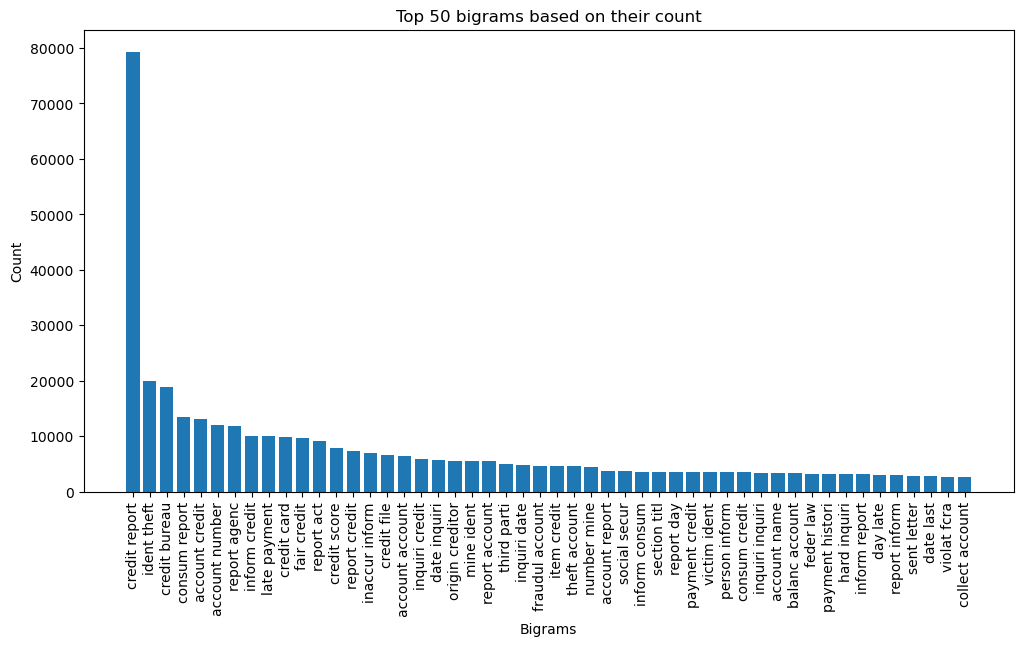

Top 50 bigrams and their frequency:
{'credit report': 1.1673041840757958, 'ident theft': 0.2929294415347496, 'credit bureau': 0.2786588595303949, 'consum report': 0.19797857941505326, 'account credit': 0.19216736303183665, 'account number': 0.17582239745777672, 'report agenc': 0.1732478079209086, 'inform credit': 0.14826693344318248, 'late payment': 0.14688401106337903, 'credit card': 0.14435355734714295, 'fair credit': 0.14092567527805566, 'report act': 0.13381980815629965, 'credit score': 0.11584181721885482, 'report credit': 0.10783852174424763, 'inaccur inform': 0.10210086506208439, 'credit file': 0.09595127405402225, 'account account': 0.0932737009356794, 'inquiri credit': 0.08619725769434473, 'date inquiri': 0.08256340846230802, 'origin creditor': 0.08248984876125463, 'mine ident': 0.08109221444124051, 'report account': 0.0803419054904961, 'third parti': 0.07213264285293945, 'inquiri date': 0.07008768316365563, 'fraudul account': 0.06805743541458248, 'item credit': 0.067763196610

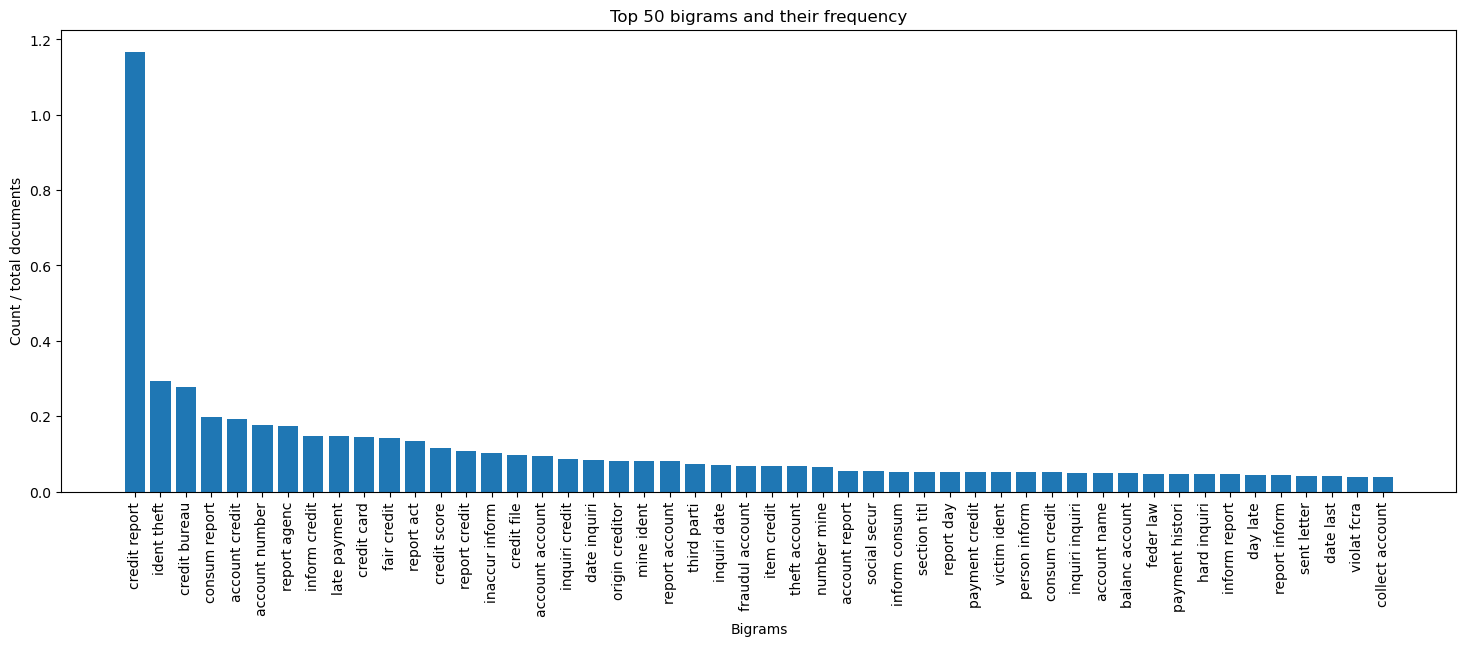

In [11]:
# Determining the top 50 bigrams based on their count over all complaints and plot the results in a bar chart
corpus_Top50 = df['bigrams'].tolist()
list_of_lists = [word for sublist in corpus_Top50 for word in sublist]
word_freq = FreqDist(list_of_lists)
top_50_words = dict(word_freq.most_common(50))

print("Top 50 most common bigrams:")
print(word_freq.most_common(50))

plt.figure(figsize=(12,6))
plt.bar(top_50_words.keys(), top_50_words.values())
plt.xticks(rotation='vertical')
plt.title('Top 50 bigrams based on their count')
plt.xlabel('Bigrams')
plt.ylabel('Count')
plt.show()


# Determining the number of documents in order to calculate frequency share for the top 50 bigrams, i.e, on average, in how many documents is the bigram appearing
no_documents = len(df)
word_freq_share = {word: freq / no_documents for word, freq in top_50_words.items()}

print("Top 50 bigrams and their frequency:")
print(word_freq_share)

plt.figure(figsize=(18,6))
plt.bar(list(word_freq_share.keys())[:50], list(word_freq_share.values())[:50])
plt.xticks(rotation='vertical')
plt.title('Top 50 bigrams and their frequency')
plt.xlabel('Bigrams')
plt.ylabel('Count / total documents')
plt.show()

In [12]:
# Removal of bigrams which are occuring too often (>=0.5)
frequency_threshold = 0.5

tokenized_data = df['bigrams']
list_tokenized_data = df['bigrams'].tolist()
list_of_lists_full = [word for sublist in list_tokenized_data for word in sublist]

word_freq_full = FreqDist(list_of_lists_full)
words_full = dict(word_freq_full)
no_documents_full = len(df)
word_freq_share_full = {word: freq / no_documents_full for word, freq in words_full.items()}

filtered_data = [[word for word in doc if word_freq_share_full[word] <= frequency_threshold] for doc in tokenized_data]

# (4) Vectorization

## (4.1) BoW

In [13]:
# Using gensim for BoW vectorization as a basis for subsequent topic modeling
# Defining a corpus and dictionary is the basic for vectorization in gensim
corpus = filtered_data
dictionary = corpora.Dictionary(corpus)

# Filtering out bigrams that occur too frequently or too rarely
# Too frequently is added despite having filtered out bigrams above based on their frequency as the approach here is slightly different
# Based on below values, documents are filtered out which occur in less than 10 documents or occur in more than 95% of documents
dictionary.filter_extremes(no_below=10, no_above=0.95)
bow = [dictionary.doc2bow(text) for text in corpus] 
id_words_bow = [[(dictionary[id], count) for id, count in line] for line in bow]

# Printing of first five results as exemplary output
print(id_words_bow[:5])


[[('abil credit', 1), ('account abil', 1), ('account demand', 1), ('account failur', 1), ('account inquiri', 1), ('account name', 1), ('account note', 1), ('account number', 1), ('account type', 1), ('account unabl', 1), ('accur inform', 1), ('accuraci complet', 1), ('act financi', 1), ('act section', 2), ('action compani', 1), ('action method', 1), ('add promot', 1), ('anyon report', 1), ('care record', 1), ('certifi letter', 1), ('claim action', 1), ('compani violat', 1), ('complet inform', 1), ('complet investig', 1), ('consent verif', 1), ('consum contract', 2), ('contract post', 1), ('contract signatur', 1), ('copi verifi', 1), ('credit act', 1), ('credit fcra', 1), ('credit file', 1), ('date remov', 1), ('day certifi', 1), ('day complet', 2), ('day old', 1), ('debt buyer', 1), ('defam neglig', 1), ('demand account', 1), ('demand verifi', 1), ('descript procedur', 1), ('detail number', 1), ('determin accuraci', 1), ('disput review', 1), ('enabl ident', 1), ('failur respond', 1), (

## (4.2) TF-IDF 

In [14]:
# Using gensim for TFIDF vectorization as a basis for subsequent topic modeling
# Commented out here as BoW is taken based on results of V6

#tfidf_model = TfidfModel(dictionary=dictionary, smartirs='ntc')
#tfidf = [tfidf_model[dictionary.doc2bow(text)] for text in corpus]

#id_words_tfidf = [[(dictionary[id], np.around(freq,decimals=2)) for id, freq in line] for line in tfidf_model[bow]]

# Printing of first five results as exemplary output
#print(id_words_tfidf[:5])


# (5) Topic Modeling

## (5.1) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with BoW

In [15]:
# Running the LSI model based on BoW vectorization and calculating the coherence score for 2 - 20 topics including plotting the results in a line chart
# The result is taken as a basis to decide on an optimal number of topics for LSI
# Commented out here as LDA with BoW is taken based on results of V6

#topics = []
#score=[]

#for i in range(2,21):
    #lsi = LsiModel(bow, num_topics = i, id2word = dictionary, power_iters=10)
    #coherence_model = CoherenceModel(model=lsi, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    #coherence_score = coherence_model.get_coherence()
    #print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    
    #topics.append(i)
    #score.append(coherence_model.get_coherence())
    
#_=plt.plot(topics, score)
#_=plt.xlabel('Number of Topics')
#_=plt.ylabel('Coherence Score')
#plt.show()


# For training purposes in V1 - V5, the maxium score has been selected by default to let the subsequent model continue running automatically
# This has been taken as a basis for comparing model performance
# This code is commented out in the final version as the optimal number of topics is decided on based on visual investigation
# Simply taking the max coherence score might not always be the best choice

#topic_score_dict = dict(zip(topics, score))
#max_dict = max(zip(topic_score_dict.values(),topic_score_dict.keys()))[1]
#print(max_dict)

## (5.2) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with Tf-Idf

In [16]:
# Running the LSI model based on tfidf vectorization and calculating the coherence score for 2 - 20 topics including plotting the results in a line chart
# The result is taken as a basis to decide on an optimal number of topics for LSI
# Commented out here as LDA with BoW is taken based on results of V6

#topics_LSI_tfidf = []
#score_LSI_tfidf=[]

#for i in range(2,21):
    #lsi_tfidf = LsiModel(tfidf, num_topics = i, id2word = dictionary, power_iters = 10)
    #coherence_model_tfidf = CoherenceModel(model=lsi_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    #coherence_score_tfidf = coherence_model_tfidf.get_coherence()
    #print('Coherence score with {} clusters: {}'.format(i, coherence_score_tfidf))
    
    #topics_LSI_tfidf.append(i)
    #score_LSI_tfidf.append(coherence_model_tfidf.get_coherence())
    
#_=plt.plot(topics_LSI_tfidf, score_LSI_tfidf)
#_=plt.xlabel('Number of Topics')
#_=plt.ylabel('Coherence Score')
#plt.show()

# Following comments are the same as for LSI with BoW
# For training purposes in V1 - V5, the maxium score has been selected by default to let the subsequent model continue running automatically
# This has been taken as a basis for comparing model performance
# This code is commented out in the final version as the optimal number of topics is decided on based on visual investigation
# Simply taking the max coherence score might not always be the best choice

#topic_score_dict_tfidf = dict(zip(topics_LSI_tfidf, score_LSI_tfidf))
#max_dict_tfidf = max(zip(topic_score_dict_tfidf.values(),topic_score_dict_tfidf.keys()))[1]
#print(max_dict_tfidf)


## (5.3) Latent Dirichlet Allocation (LDA) with BoW

In [17]:
# Running the LDA model based on BoW vectorization and calculating the coherence score for 2 - 20 topics including plotting the results in a line chart
# The result is taken as a basis to decide on an optimal number of topics for LDA

df['Assigned_topic_lda_bow'] = None
df['Topic_score_lda_bow'] = None

# Commented out here as, based on results of V6, 6 topics will be chosen

#topics_LDA_bow = []
#score_LDA_bow=[]

#for i in range(2,21):
    #lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = i, iterations = 100)
    #coherence_model_lda_bow = CoherenceModel(model=lda_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    #coherence_score_lda_bow = coherence_model_lda_bow.get_coherence()
    #print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_bow))
    
    #topics_LDA_bow.append(i)
    #score_LDA_bow.append(coherence_model_lda_bow.get_coherence())
    
#_=plt.plot(topics_LDA_bow, score_LDA_bow)
#_=plt.xlabel('Number of Topics')
#_=plt.ylabel('Coherence Score')
#plt.show()

# For training purposes in V1 - V5, the maxium score has been selected by default to let the subsequent model continue running automatically
# This has been taken as a basis for comparing model performance
# This code is commented out in the final version as the optimal number of topics is decided on based on visual investigation
# Simply taking the max coherence score might not always be the best choice

#topic_score_dict_lda_bow = dict(zip(topics_LDA_bow, score_LDA_bow))
#max_dict_lda_bow = max(zip(topic_score_dict_lda_bow.values(),topic_score_dict_lda_bow.keys()))[1]
#print(max_dict_lda_bow)

lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = 6, iterations = 100)

# Show top 10 words of each of the n topics
for topic_num, words in lda_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))
    
# Assigning topics to each document and showing the top 5 documents for each topic
# Taken as a basis for determining the content of each topic
topic_space_lda_bow = lda_bow[bow]

for i, (row_index, topic_distribution) in enumerate(zip(df.index,topic_space_lda_bow)):
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    #print('Row {}: Assigned Topic - {}, Score - {}'.format(i, dominant_topic[0], dominant_topic[1]))
    topic, topic_score = max(topic_distribution, key = lambda x: abs(x[1]))
    df.at[row_index,'Assigned_topic_lda_bow']=dominant_topic[0]
    df.at[row_index,'Topic_score_lda_bow']=dominant_topic[1]
    
df_lda_bow = df[['Complaint ID','Consumer complaint narrative', 'Assigned_topic_lda_bow','Topic_score_lda_bow']] 

df_sorted_lda_bow = df_lda_bow.sort_values(by=['Assigned_topic_lda_bow','Topic_score_lda_bow'],ascending=[True,False])

# Looking at the top 5 documents with the highest topic score lower than 0.9 
# This is in order to avoid looking at identical documents which have not been captured by removing duplications when deriving the topics
df_sorted_lda_bow = df_sorted_lda_bow[(df_sorted_lda_bow['Topic_score_lda_bow'] <= 0.9)]

df_sorted_lda_bow = df_sorted_lda_bow.groupby('Assigned_topic_lda_bow').head(5)

pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.width', 150)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
display(df_sorted_lda_bow)


Words in 0: 0.017*"late payment" + 0.015*"credit bureau" + 0.011*"credit score" + 0.006*"report account" + 0.006*"account credit" + 0.006*"payment histori" + 0.005*"date last" + 0.005*"day late" + 0.004*"payment credit" + 0.004*"inform credit".
Words in 1: 0.038*"consum report" + 0.021*"report agenc" + 0.015*"ident theft" + 0.009*"inform consum" + 0.008*"consum credit" + 0.005*"fair credit" + 0.005*"consum right" + 0.005*"report act" + 0.004*"pursuant usc" + 0.004*"permiss purpos".
Words in 2: 0.015*"credit bureau" + 0.011*"credit card" + 0.010*"inquiri credit" + 0.008*"inquiri inquiri" + 0.007*"account credit" + 0.007*"credit file" + 0.007*"report act" + 0.006*"inform credit" + 0.006*"fair credit" + 0.006*"report credit".
Words in 3: 0.006*"debt collect" + 0.006*"origin creditor" + 0.005*"valid debt" + 0.005*"inform credit" + 0.005*"feder law" + 0.005*"account credit" + 0.004*"debt collector" + 0.003*"report act" + 0.003*"fraudul account" + 0.003*"fair credit".
Words in 4: 0.061*"iden

,Complaint ID,Consumer complaint narrative,Assigned_topic_lda_bow,Topic_score_lda_bow
334818,4708592,"XXXX / XXXX XXXX is reporting inaccurate information on my credit report. We have a hardship agreement in place since XX/XX/XXXX XX/XX/XXXX and in addition, we have a new hardship agreement in place in XX/XX/XXXX for one year.\n\nAccording to the Cares Act, they are not to report any damaging payment history that would hurt my credit if our account has been modified, which includes a hardship agreement since XX/XX/XXXX for one year and again in XX/XX/XXXX. We have agreed for a reduced payment and paid while under the hardship agreement. We have also caught up-to-date and now paying more than full payments since XX/XX/XXXX without missing any payments. XXXX is aware of this issue and promises to correct the payment history. In addition, XXXX said to dispute with the credit bureaus, and they will correct with no late payment history. Please correct the payment history as paid-as-agreed and Current on payments in the payment history as agreed to by law.",0,0.899839
417666,4273270,"NelNet Loan services purchased my ( 1 ) one student loan and during this time has been reporting to my credit inaccurately. The credit report shows that a payment has been made each month but then the overview states that the last payment was made in XX/XX/2019. NelNet is also duplicate reporting with ( 2 ) two different loan numbers but almost the same payment data. Having 2 student loans is bringing my score down, not to mention the fact that they are reporting this late as well. To be clear, I have only ONE student loan. I am not a co-signer on any other student loan obligations. \nI have disputed this thru XXXX XXXX and XXXX XX/XX/2019 and they state it is accurate. I am trying to buy a home and this loan is hindering these possibilities.",0,0.89933
173851,4394598,"On or about XXXX XXXX after my car was repossessed by my lien holder who never disclosed as a debt collector I looked into my XXXX XXXX account for my credit report as both XXXX and XXXX both regularly update my history my score and my report and I saw where it says XXXX loan and it identified as the number XXXX and then under account closed as a charge off and a write off as of XX/XX/XXXX account closed profit /loss and last payment made XX/XX/XXXX And no derogatory remarks and no collection marks So I proceed to call Santander consumer the lien holder/debt collector and ask how is it that they are able to use a car as security on a debt that doesnt even exist? They were adamant about it being a charge of and said itd just the credit bureaus!! So Im not understanding what he means by this did i miss something? I was just informed that he told me that the debt was reported to the shareholders of the company, Im not making this up, and the shareholders are writing it off as a loss of a unfulfilled contract. So Im assuming that since they made the loss a tax deductible loss and the debt no longer exists Im not so sure that I have had my property seized legally and then why on XX/XX/XXXX I dispute the bureau both of them on my credit karma account and find five days later the disputes have been remedied and the result was exactly the same thing, yet on XX/XX/XXXX I was really not happy to see my XXXX credit report that showed my Santander account to be delinquent not just once in XXXX but 2x yes on XX/XX/XXXX and on XX/XX/XXXX both were reported as delinquent and no charge off no recovery no bad debt last payment XXXX. I have made XXXX $ in payments to that account since XX/XX/XXXX and Ive yet to receive not one call from any debt collection agency not even one! So they told me themselves that they are the one who is collecting the debt yet they say that they already reported it as a loss to their shareholders! And some times when I call them they identify as an attempt to collect a debt and sometimes they dont! So how do I know which one Im talking to? And even since my dispute on my own be

## (5.4) Latent Dirichlet Allocation (LDA) with Tf-Idf

In [18]:
# Running the LDA model based on Tfidf vectorization and calculating the coherence score for 2 - 20 topics including plotting the results in a line chart
# The result is taken as a basis to decide on an optimal number of topics for LDA
# Commented out here as LDA with BoW is taken based on results of V6

#topics_LDA_tfidf = []
#score_LDA_tfidf=[]

#for i in range(2,21):
    #lda_tfidf = LdaModel(corpus=tfidf,id2word=dictionary, num_topics = i, iterations = 100)
    #coherence_model_lda_tfidf = CoherenceModel(model=lda_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    #coherence_score_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
    #print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_tfidf))
    
    #topics_LDA_tfidf.append(i)
    #score_LDA_tfidf.append(coherence_model_lda_tfidf.get_coherence())
    
#_=plt.plot(topics_LDA_tfidf, score_LDA_tfidf)
#_=plt.xlabel('Number of Topics')
#_=plt.ylabel('Coherence Score')
#plt.show()

# For training purposes in V1 - V5, the maxium score has been selected by default to let the subsequent model continue running automatically
# This has been taken as a basis for comparing model performance
# This code is commented out in the final version as the optimal number of topics is decided on based on visual investigation
# Simply taking the max coherence score might not always be the best choice

#topic_score_dict_lda_tfidf = dict(zip(topics_LDA_tfidf, score_LDA_tfidf))
#max_dict_lda_tfidf = max(zip(topic_score_dict_lda_tfidf.values(),topic_score_dict_lda_tfidf.keys()))[1]
#print(max_dict_lda_tfidf)

## (5.5) Hierarchical Dirichlet Process (HDP) with BoW

In [19]:
# Running the HDP model based on BoW vectorization and calculating the coherence score
# Number of topics does not have to be identified as HDP is finding the optimal number of topics itself
# Commented out here as LDA with BoW is taken based on results of V6

#hdp_bow = HdpModel(corpus=bow,id2word=dictionary, alpha=0.1, gamma=0.1, chunksize = 1000,random_state = 42)

# Show top 10 words of each of the topics

#for topic_num, words in hdp_bow.print_topics(num_words=10):
    #print('Words in {}: {}.'.format(topic_num, words))
    
#no_topics = topic_num

In [20]:
# Topic Coherence for HDP with BoW
# Commented out here as LDA with BoW is taken based on results of V6

#coherence_model_hdp_bow = CoherenceModel(model=hdp_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
#coherence_score_hdp_bow = coherence_model_hdp_bow.get_coherence()
#print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_bow))

## (5.6) Hierarchical Dirichlet Process (HDP) with Tf-Idf

In [21]:
# Running the HDP model based on Tfidf vectorization and calculating the coherence score
# Number of topics does not have to be identified as HDP is finding the optimal number of topics itself
# Commented out here as LDA with BoW is taken based on results of V6

#hdp_tfidf = HdpModel(corpus=tfidf,id2word=dictionary,alpha=0.1, gamma=0.1, chunksize = 1000,random_state = 42)

# Show top 10 words of each of the topics
#for topic_num, words in hdp_tfidf.print_topics(num_words=10):
    #print('Words in {}: {}.'.format(topic_num, words))

In [22]:
# Topic Coherence for HDP with Tfidf
# Commented out here as LDA with BoW is taken based on results of V6

#coherence_model_hdp_tfidf = CoherenceModel(model=hdp_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
#coherence_score_hdp_tfidf = coherence_model_hdp_tfidf.get_coherence()
#print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_tfidf))

# (6) Result Discussion

Based on the top 10 words and top 5 documents for each topic as a result of LDA with BoW, the following six topics are suggested:
(1) Inaccurate late payment credit reporting
(2) Breach of privacy rights and authorization concepts
(3) Inaccurate hard inquiries
(4) Incorrect/unkown credit accounts
(5) Identify theft
(6) Missing/late responses on deletion of inaccurate accounts